# Lab 6
This is the jupyter notebook for lab 6. First we will import some libraries and functions. 

In [12]:
from numpy import genfromtxt
import numpy as np
from netCDF4 import MFDataset 
from netCDF4 import Dataset 
import matplotlib
matplotlib.use('Agg')
import matplotlib.pylab as plt
from mpl_toolkits.basemap import Basemap
from datetime import datetime
from netCDF4 import num2date
from netCDF4 import date2index
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
from metpy.units import units
import xarray as xr
import cartopy.util as cutil
%matplotlib inline

Our next setep is to read in the netCDF files. 

In [13]:
ds = xr.open_dataset('https://psl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/air.mon.mean.nc')
ds2 = xr.open_dataset('https://psl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/hgt.mon.mean.nc')
ds3 = xr.open_dataset('https://psl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/uwnd.mon.mean.nc')
ds4 = xr.open_dataset('https://psl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/vwnd.mon.mean.nc')


Provide the pressure level and month you wish to plot. Also provide the month as a string, so our caption is attractive. 

In [14]:
plevel = 500
month = 1
monthlabel = 'January'
tm = int(month)-1

Now we extract the data desired. 

In [24]:
# Grab lat/lon values
lats = ds.lat.data
lons = ds.lon.data

#subtract 1 from tm because the first observation in Python is observation 0

temp = ds.air.sel(level=plevel)[tm::12,:,:].values
hght = ds2.hgt.sel(level=plevel)[tm::12,:,:].values
uwnd = ds3.uwnd.sel(level=plevel).values[:][tm::12,:,:] * units('m/s')
vwnd = ds4.vwnd.sel(level=plevel).values[:][tm::12,:,:] * units('m/s')


Print the numpy shapes of the temperature, latitude and longtitude. This can be important when debugging.

In [25]:
print (np.shape(temp))
print (np.shape(lats))
print (np.shape(lons))

(73, 73, 144)
(73,)
(144,)


Now we need to read in your index data, in a csv file with the year and monthly values in columns. (Without column labels)

In [26]:
sourcefile = open('index.csv','rb')
indexdata = genfromtxt(sourcefile,delimiter=',')
print(np.shape(indexdata))

(67, 2)


Plot the time series

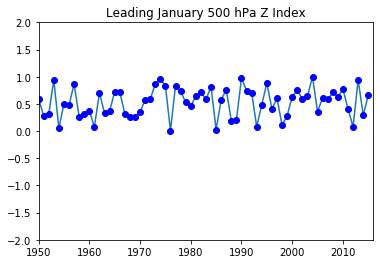

In [27]:
plt.plot(indexdata[0:66,0],indexdata[0:66,1])
plt.plot(indexdata[0:66,0],indexdata[0:66,1], 'bo')
plt.axis([1950, 2016, -2, 2])
plt.title('Leading January 500 hPa Z Index')
plt.show()

Time for a histogram!

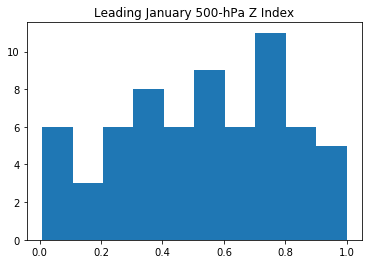

In [19]:
plt.hist(indexdata[0:66,1])
plt.title('Leading January 500-hPa Z Index')
plt.show()

What are the mean and standard deviation?

In [28]:
print(np.mean(indexdata[0:66,1]))
print(np.std(indexdata[0:66,1]))

0.5289786948636365
0.2636243293554738


Now we calculate the correlation field between the index and the 500 hPa Z. The first step is to make objects with the right dimensions, before we can copy the correlation values. Note that the data is subset to leave off the first two years, for which the NAO data is not available. (The final year is left off too, since it is NA for some of the months.) 

In [29]:
hgtcor=np.zeros((hght.shape[1],hght.shape[2]))
tempcor=np.zeros((temp.shape[1],temp.shape[2]))

for i in range(hght.shape[1]):
    for j in range(hght.shape[2]):
       hgtcor[i,j] = np.corrcoef(hght[2:68,i,j], indexdata[0:66,1])[1,0]
       tempcor[i,j] = np.corrcoef(temp[2:68,i,j], indexdata[0:66,1])[1,0]


Select the countour settings for the correlation map

In [30]:
clevs_cor = np.arange(-1,1.1,0.1)

In [31]:
print(np.min(hgtcor))

-0.31104184180175903


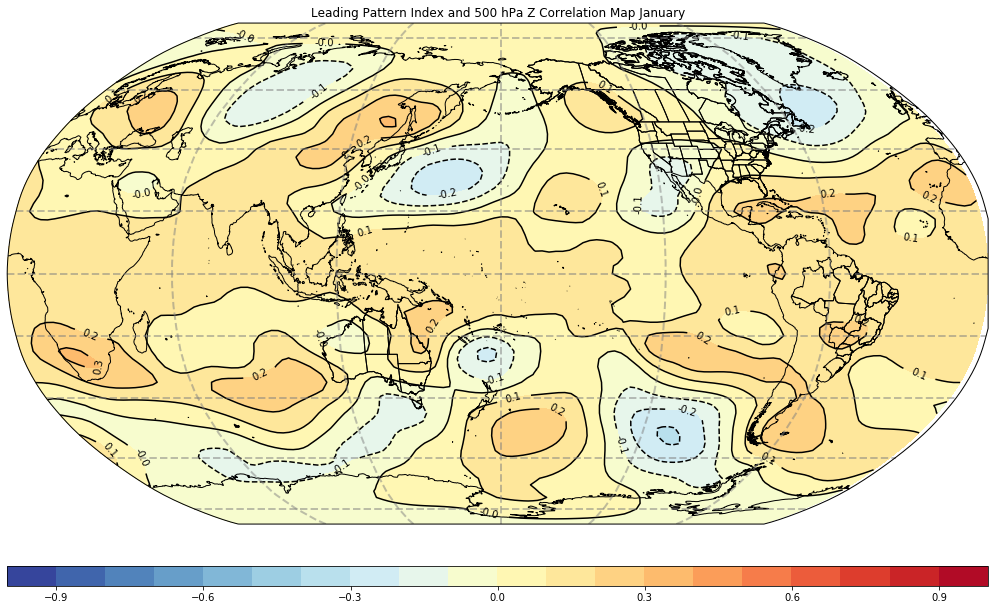

In [32]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.Robinson(central_longitude=180)

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)

#not needed here, but used for sub-setting domain to plot
#ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))
gl = ax.gridlines(color='gray',linewidth=2, alpha = 0.5, linestyle='--')

# labels gridlines for PlateCarree ccrs option (doesn't work with Robinson, etc.)
#gl.xlabels_top = False
#gl.ylabels_right = False

#color-filled contour time!
#plotting temperature and including color bar
cf = ax.contourf(lons, lats, hgtcor, clevs_cor, cmap=plt.cm.RdYlBu_r, transform=datacrs)

plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)

# Plot 500-hPa Geopotential Height Anomaly in meters
#cs = ax.contour(lons, lats, hght[ty,:,:] - np.mean(hght[:,:,:],axis=0), clevs_hght_anom, colors='black', transform=datacrs)
#plt.clabel(cs, fmt='%d')

# Plot 500-hPa Geopotential Heights in meters
cs = ax.contour(lons, lats, hgtcor, clevs_cor, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%1.1f')

# Plot 500-hPa wind barbs in knots, regrid to reduce number of barbs
#ax.barbs(lons[::4], lats[::4], uwnd.to('kt')[ty,::4,::4].m, 
#         vwnd.to('kt')[ty,::4,::4].m, pivot='middle',
#         color='black', transform=datacrs, length=5, linewidth=0.4)

# Make some nice titles for the plot (one right, one left)
plt.title('Leading Pattern Index and 500 hPa Z Correlation Map ' + str(monthlabel))

# Reduce excessive white space around image and show
plt.tight_layout()
plt.savefig('Indexand500hPaZcorrelationmap' + str(monthlabel), dpi=150)
plt.show()

Time to read in another group's index, for comparison. (Make sure to change the file name, so you don't over-write your file!)

In [33]:
sourcefile2 = open('index2.csv','rb')
indexdata2 = genfromtxt(sourcefile2,delimiter=',')
print(np.shape(indexdata2))

(67, 2)


For time time series and histogram plots, as well as mean and standard deviation, you can insert new cells below and type in (or copy) the appropriate commands. Just change indexdata to indexdata2 and change the plot titles as appropriate.  


Make a scatter plot of your leading index and their index!

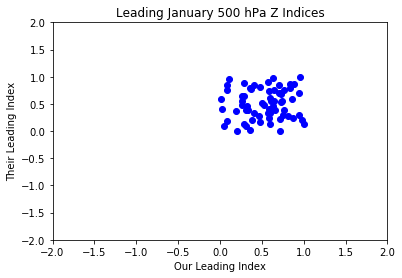

In [34]:
plt.plot(indexdata[0:66,1],indexdata2[0:66,1], 'bo')
plt.axis([-2, 2, -2, 2])
plt.title('Leading January 500 hPa Z Indices')
plt.xlabel('Our Leading Index')
plt.ylabel('Their Leading Index')
plt.show()

In [35]:
print('correlation of the 2 indices')
print(np.corrcoef(indexdata[0:66,1],indexdata2[0:66,1])[0,1])

correlation of the 2 indices
0.0766848534249979
